### Dataset Sources

Beat Acute Myeloid Leukemia (AML) 1.0 was accessed on 13Mar2023 from https://registry.opendata.aws/beataml. OHSU BeatAML Datasets Link: https://ctd2-data.nci.nih.gov/Public/OHSU-1/BeatAML_Waves1_2/

OpenCell Datasets Link: https://opencell.czbiohub.org/download

### Dataset S3 Location

Importing Raw Datasets from AWS S3. Use the AWS Command Line Interface (CLI) to list the S3 bucket content using the following CLI commands:

In [ ]:
!aws s3 ls s3://team4rawdatasets/CSV/Input/OHSU_BeatAML_ClinicalSummary/

In [103]:
!aws s3 ls s3://team4rawdatasets/CSV/Input/OpenCell_ProteinInteraction/

2023-03-21 02:37:38          0 
2023-03-21 02:38:40    4568928 opencell-protein-interactions.csv


### Check Pre-Requisites from the `01_setup/` Folder

In [104]:
%store -r setup_instance_check_passed

In [105]:
try:
    setup_instance_check_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Instance Check.")
    print("+++++++++++++++++++++++++++++++")

In [106]:
print(setup_instance_check_passed)

True


In [107]:
%store -r setup_dependencies_passed

In [108]:
try:
    setup_dependencies_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++")

In [109]:
print(setup_dependencies_passed)

True


In [110]:
%store -r setup_s3_bucket_passed

In [111]:
try:
    setup_s3_bucket_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup S3 Bucket.")
    print("+++++++++++++++++++++++++++++++")

In [112]:
print(setup_s3_bucket_passed)

True


In [113]:
%store -r setup_iam_roles_passed

In [114]:
try:
    setup_iam_roles_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++")

In [115]:
print(setup_iam_roles_passed)

True


In [116]:
if not setup_instance_check_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Instance Check.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_dependencies_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_s3_bucket_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup S3 Bucket.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_iam_roles_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

In [117]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

### Set S3 Source Location

In [118]:
#BeatAML Clinical Summary
s3_public_path_clsm = "s3://team4rawdatasets/CSV/Input/OHSU_BeatAML_ClinicalSummary/"

In [119]:
%store s3_public_path_clsm

Stored 's3_public_path_clsm' (str)


In [120]:
print(s3_public_path_clsm)

s3://team4rawdatasets/CSV/Input/OHSU_BeatAML_ClinicalSummary/


In [121]:
!aws s3 ls $s3_public_path_clsm

2023-03-21 02:37:21          0 
2023-03-21 02:38:06     712633 OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv


In [122]:
#BeatAML OpenCell Protein Interaction
s3_public_path_pi = "s3://team4rawdatasets/CSV/Input/OpenCell_ProteinInteraction/"

In [123]:
%store s3_public_path_pi

Stored 's3_public_path_pi' (str)


In [124]:
print(s3_public_path_pi)

s3://team4rawdatasets/CSV/Input/OpenCell_ProteinInteraction/


In [125]:
!aws s3 ls $s3_public_path_pi

2023-03-21 02:37:38          0 
2023-03-21 02:38:40    4568928 opencell-protein-interactions.csv


In [126]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/team4rawdatasets?prefix=CSV/Input/&region=us-east-1">S3 Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

### Athena Database

[PyAthena](https://pypi.org/project/PyAthena/) is a Python DB API 2.0 (PEP 249) compliant client for Amazon Athena.

In [127]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [128]:
ingest_create_athena_db_passed = False

In [129]:
database_name = "bcr"

In [130]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [131]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [132]:
statement0 = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement0)

CREATE DATABASE IF NOT EXISTS bcr


In [133]:
pd.read_sql(statement0, conn)

""


### Verify The Database Has Been Created Succesfully

In [134]:
statement00 = "SHOW DATABASES"

df_show = pd.read_sql(statement00, conn)
df_show.head(5)

,database_name
0,bcr
1,default
2,dsoaws


In [135]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [136]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


### Athena Table Created Through AWS Glue Crawler

In [137]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="top" href="https://us-east-1.console.aws.amazon.com/glue/home?region=us-east-1#/v2/data-catalog/tables">AWS Glue Catalog</a></b>'.format(
            region
        )
    )
)

### Athena Sample Query

In [138]:
# Set Athena database & table
table_clsm = "ohsu_beataml_clinicalsummary"
table_pi = "opencell_proteininteraction"

In [139]:
#Athena SQL Code
statement1 = """
SELECT *
FROM {}.{} 
""".format(
    database_name, table_pi
)

print(statement1)


SELECT *
FROM bcr.opencell_proteininteraction 



In [140]:
pi = pd.read_sql(statement1, conn)
pi.head(5)

,target_gene_name,interactor_gene_name,target_ensg_id,interactor_ensg_id,interactor_uniprot_ids,pval,enrichment,interaction_stoichiometry,abundance_stoichiometry
0,AAMP,ARGLU1,ENSG00000127837,ENSG00000134884,Q9NWB6;Q9NWB6-3;Q9NWB6-2,5.495914,2.868131,0.128617729227485,0.222926886757708
1,AAMP,CWF19L2,ENSG00000127837,ENSG00000152404,Q2TBE0;Q2TBE0-2;H7C3G7;Q2TBE0-3;H0YE03,5.480125,2.889502,0.0220086333382949,0.0630363097469908
2,AAMP,PRPF40A,ENSG00000127837,ENSG00000196504,A0A3F2YNY6;O75400-2;O75400-3;O75400;H0YG38;F5H578,5.321102,3.228531,0.00158221475294645,0.74201685528861
3,AAMP,RPL10,ENSG00000127837,ENSG00000147403,X1WI28;P27635;B8A6G2;A6QRI9;Q96L21,15.156173,4.847218,0.521148076897205,13.1469097118672
4,AAMP,RSRC1,ENSG00000127837,ENSG00000174891,Q96IZ7-2;Q96IZ7;H7C5Q0;C9J713;C9J367;C9J8Q2;C9...,5.929453,3.239392,0.0131705143900265,0.210925681027771


In [141]:
if not pi.empty:
    print("[OK]")
else:
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOUR DATA HAS NOT BEEN CONVERTED TO PARQUET. LOOK IN PREVIOUS CELLS TO FIND THE ISSUE.")
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")

[OK]


# Preliminary Visualization

### Import Tools: 

In [142]:
!pip install klib

In [143]:
import numpy as np
import seaborn as sns
import klib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

### OHSU BeatAML Clinical Summary Table

In [144]:
# SQL statement
statement2 = """
SELECT *
FROM {}.{} 
""".format(
    database_name, table_clsm
)

print(statement2)


SELECT *
FROM bcr.ohsu_beataml_clinicalsummary 



In [145]:
clsm = pd.read_sql(statement2, conn)
clsm.head(5)

,labid,patientid,consensus_sex,inferred_sex,inferred_ethnicity,centerid,cebpa_biallelic,ageatdiagnosis,isrelapse,isdenovo,...,stag2,stat3,suz12,tcl1a,tet2,tp53,tyk2,u2af1,wt1,zrsr2
0,15-00248,2033,Male,Male,HispNative,2,n,61.0,False,True,...,,,,A318V; MAf 37%,negative,negative,,,,
1,15-00261,2052,Female,Female,White,1,n,43.0,False,True,...,,,,,,,p.E261fs*2; MAF 52%,,,negative
2,15-00269,2053,Male,Male,White,2,n,59.0,False,True,...,,,,,,,,,P95R; MAF 37%,
3,15-00275,1992,Female,Female,White,5,n,53.0,False,False,...,,,,,,,,,,
4,15-00276,2059,Male,Male,White,1,n,60.0,False,True,...,,,,,,,,,,


In [146]:
clsm.info(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 159 columns):
 #    Column                                         Dtype  
---   ------                                         -----  
 0    labid                                          object 
 1    patientid                                      int64  
 2    consensus_sex                                  object 
 3    inferred_sex                                   object 
 4    inferred_ethnicity                             object 
 5    centerid                                       int64  
 6    cebpa_biallelic                                object 
 7    ageatdiagnosis                                 float64
 8    isrelapse                                      bool   
 9    isdenovo                                       bool   
 10   istransformed                                  bool   
 11   finalfusion                                    object 
 12   specificdxatacquisition_mdsmpn    

In [147]:
clsm.describe()

,patientid,centerid,ageatdiagnosis,ageatspecimenacquisition,timeofsamplecollectionrelativetoinclusion,cumulativetreatmenttypecount,cumulativetreatmentregimencount,cumulativetreatmentstagecount,responsedurationtoinductiontx,mostrecenttreatmentduration,...,ast,albumin,creatinine,hematocrit,hemoglobin,ldh,mcv,platelet.count,total.protein,wbc.count
count,672.000000,672.000000,666.000000,576.000000,579.000000,579.000000,670.000000,217.000000,122.000000,190.000000,...,366.000000,378.000000,399.000000,329.000000,329.000000,229.000000,211.000000,190.000000,201.000000,179.000000
mean,2088.020833,2.410714,57.237237,57.515625,50.430052,1.597582,2.719403,1.953917,67.868852,35.547368,...,25.259563,20.765344,18.598596,21.036930,15.372067,21.240175,106.353981,108.968421,152.165423,118.922291
std,973.372734,1.726726,17.252330,17.496129,182.956288,0.833175,1.785696,1.789293,437.946182,105.014614,...,43.645469,32.410894,32.532918,39.897413,15.173793,60.369033,347.395735,327.844861,370.099814,250.893932
min,17.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,...,-159.000000,0.000000,-3.000000,-10.000000,0.000000,0.000000,-7.000000,-20.000000,-21.000000,-18.000000
25%,1450.750000,1.000000,47.250000,47.000000,0.000000,1.000000,1.000000,1.000000,3.000000,-1.000000,...,2.000000,2.900000,1.075000,1.330000,3.600000,3.000000,3.850000,7.000000,9.000000,11.000000
50%,2016.000000,2.000000,61.000000,61.000000,0.000000,1.000000,2.000000,1.000000,4.000000,6.000000,...,16.000000,12.000000,3.900000,13.000000,9.500000,9.000000,11.600000,18.000000,71.000000,74.000000
75%,2501.500000,4.000000,71.000000,71.000000,0.000000,2.000000,4.000000,3.000000,5.000000,17.500000,...,33.000000,29.000000,25.000000,27.600000,24.400000,24.000000,32.350000,95.000000,122.000000,101.300000
max,4380.000000,7.000000,87.000000,87.000000,1496.000000,5.000000,13.000000,13.000000,4626.000000,1131.000000,...,569.000000,391.000000,343.000000,477.000000,102.000000,766.000000,2941.000000,3615.000000,4484.000000,2700.000000


### clsm Missing Values

GridSpec(6, 6)

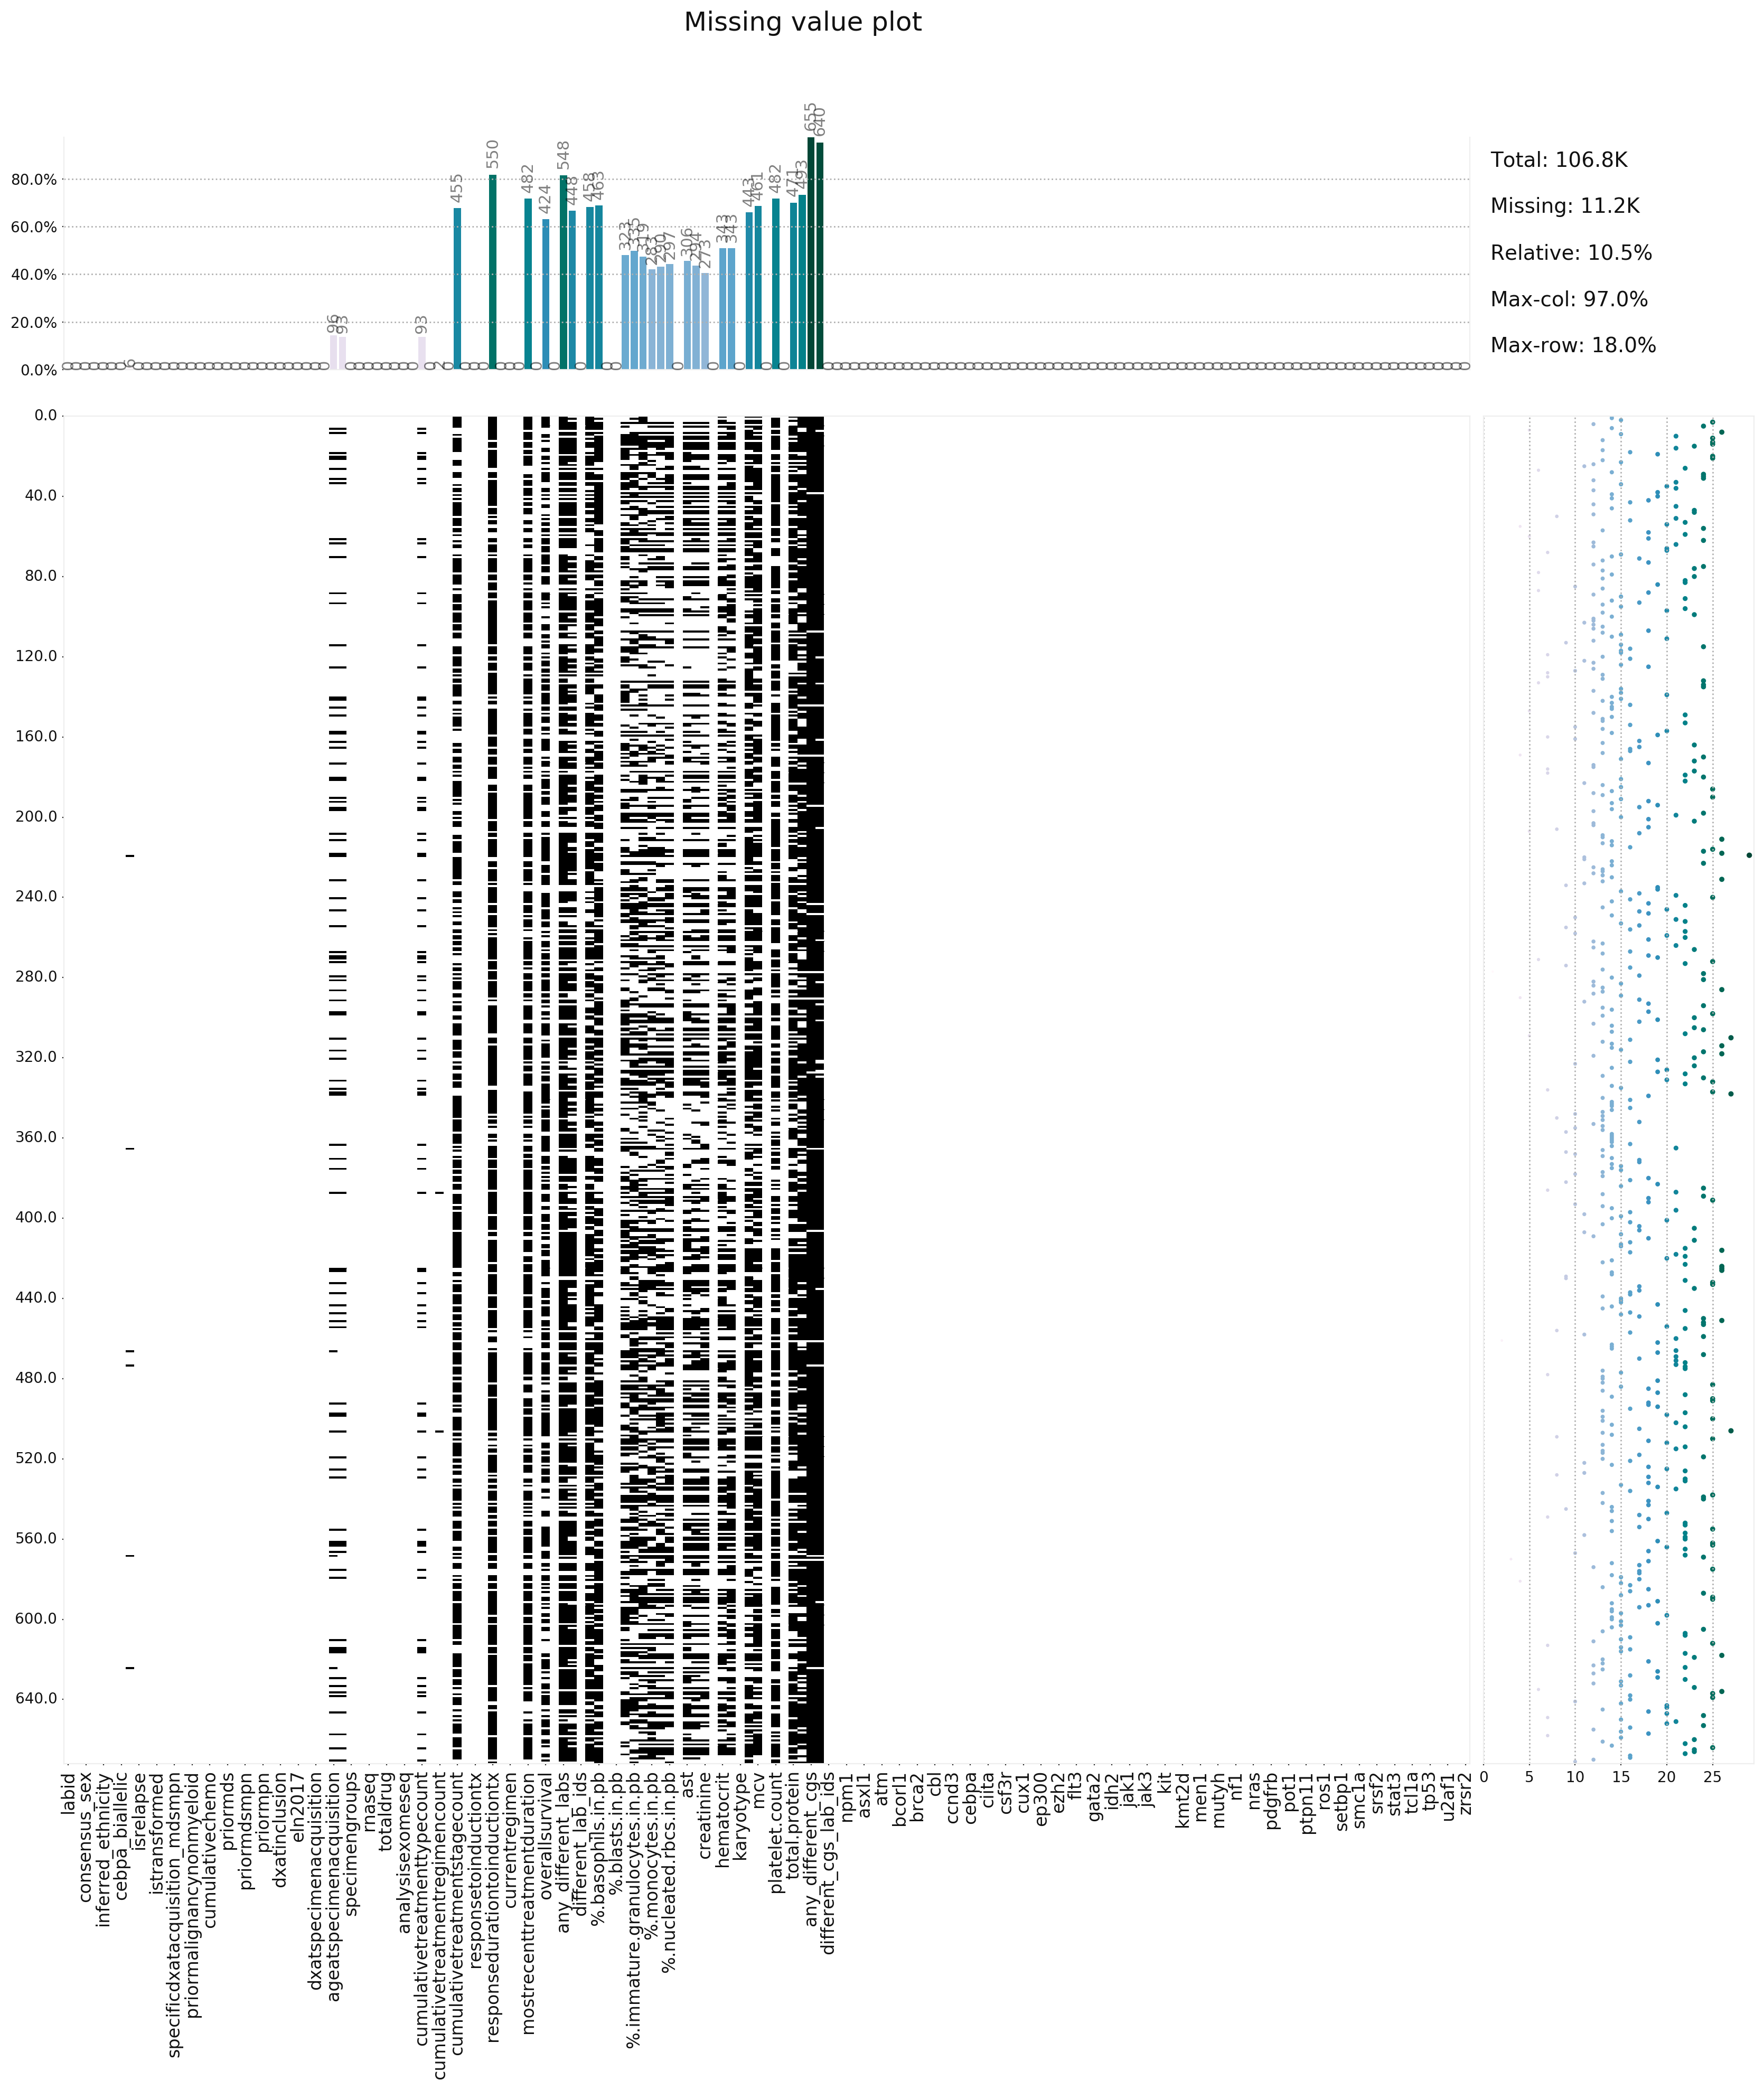

In [148]:
klib.missingval_plot(clsm)

### clsm Distribution

In [ ]:
klib.dist_plot(clsm)

Note: The number of non binary numerical features is very large (29), please consider splitting the data. Showing plots for the first 20 numerical features. Override this by setting showall=True.


# Release Resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}